In [23]:
%matplotlib inline
from modules.HandPose import HandPose
from modules.target import Target
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modules.extract_video_duration import ExtractVideoDuration
from scipy import stats

In [24]:
path_map = {}
for folder in glob.glob("../UTILS/data/VIDEO/*"):
    for file in glob.glob(folder + "/*.csv"):
        f = file.replace("\\", "/")
        key = f.split("/")[-1].split("_")[0]
        path_map[key] = f.split("_V")[0]

In [25]:
train = [(path_map[file.replace("\\", "/").split("/")[-1].split("_")[0]]) for file in glob.glob("../UTILS/data/train_set/*")]

In [26]:
test = [(path_map[file.replace("\\", "/").split("/")[-1].split("_")[0]]) for file in glob.glob("../UTILS/data/test_set/*")]

In [27]:
val = [(path_map[file.replace("\\", "/").split("/")[-1].split("_")[0]]) for file in glob.glob("../UTILS/data/val_set/*")]

In [28]:
def get_handpose_target_video(s):
    hand_pose = []
    target = []
    video_time = []
    for elem in s:
        h = HandPose(elem + "_handPose3D.txt")
        hand_pose.append(h.get_hand_pose_dict())
        target.append(Target.get(elem + "_action.json", 0))
        video_time.append(ExtractVideoDuration.get_duration(elem + "_Video.mp4"))
    return (hand_pose, target, video_time)

In [29]:
train_handpose, train_target, train_time = get_handpose_target_video(train)

In [30]:
test_handpose, test_target, test_time = get_handpose_target_video(test)

In [31]:
val_handpose, val_target, val_time = get_handpose_target_video(val)

In [32]:
def get_class_distribution(target_list, hand_dict_list):
    count_dict = {
        "Prendi": 0,
        "Rilascia": 0,
        "Premi": 0
    }
    
    class2idx = {
        "Prendi": 0,
        "Rilascia": 1,
        "Premi": 2
    }
    for target, hand_dict in zip(target_list, hand_dict_list):
        for key in hand_dict:
            start_tim = int(key)
            i = -1
            for _, val in target.items():
                if val["time"][0] <= start_tim <= val["time"][1]:
                        i = class2idx[val["action"]]
            if i == 0: 
                count_dict['Prendi'] += 1
            elif i == 1: 
                count_dict['Rilascia'] += 1
            elif i == 2: 
                count_dict['Premi'] += 1            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

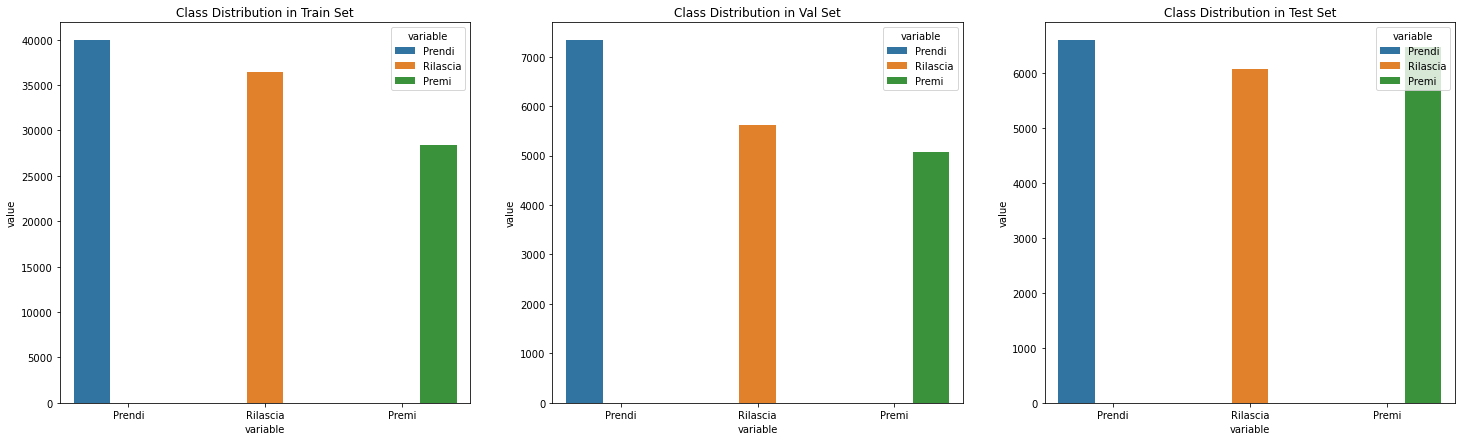

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_target, train_handpose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_target, val_handpose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_target, test_handpose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [34]:
hand_pose = train_handpose + val_handpose + test_handpose
target = train_target + val_target + test_target

Text(0.5, 1.0, 'Class Distribution')

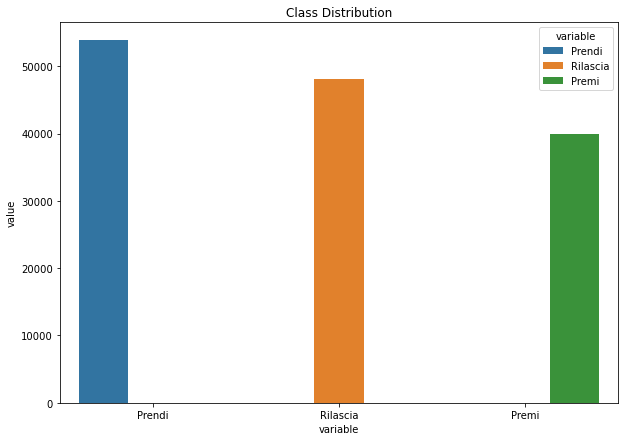

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(target, hand_pose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes).set_title('Class Distribution')

In [36]:
df = pd.DataFrame.from_dict([get_class_distribution(target, hand_pose)])

In [37]:
df.describe()

,Prendi,Rilascia,Premi
count,1.0,1.0,1.0
mean,53844.0,48103.0,39928.0
std,NaN,NaN,NaN
min,53844.0,48103.0,39928.0
25%,53844.0,48103.0,39928.0
50%,53844.0,48103.0,39928.0
75%,53844.0,48103.0,39928.0
max,53844.0,48103.0,39928.0


In [38]:
video_time = train_time + test_time + val_time
train_t = np.array(train_time)
test_t = np.array(test_time)
val_t = np.array(val_time)
video_t = np.array(video_time)

In [39]:
print(stats.describe(video_t))

DescribeResult(nobs=56, minmax=(27100, 185330), mean=78156.375, variance=964370857.9477273, skewness=1.1284695521734494, kurtosis=1.7445334178892118)


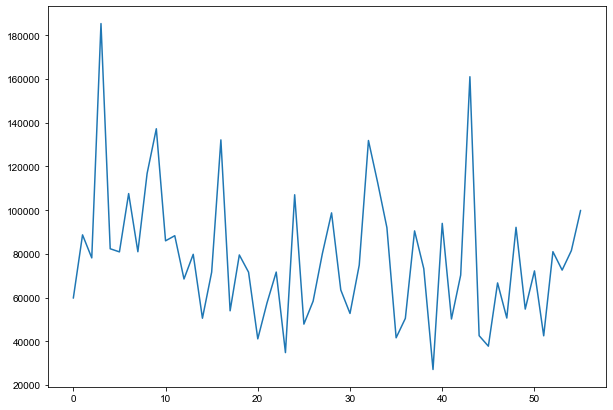

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.set_style("whitegrid")
plt.plot(video_t)
plt.show()

In [41]:
video_t.sum()

4376757

In [42]:
soggetti = 9

In [43]:
riprese_medie = len(video_t)/soggetti

In [47]:
video_person = []
for folders in glob.glob("../UTILS/data/VIDEO/*"):
    video_person.append(len(glob.glob(folders + "\\*.mp4")))

In [48]:
video_person

[6, 6, 7, 9, 6, 6, 6, 5, 5]

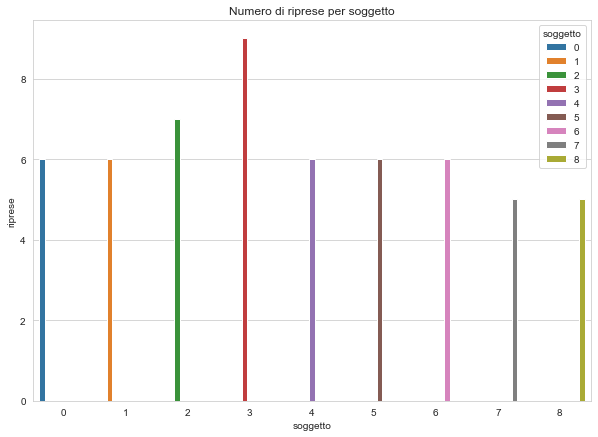

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.barplot(data = pd.DataFrame.from_dict(pd.DataFrame.from_dict([{key: val for val, key in zip(video_person, range(soggetti))}]).melt().rename(columns = {'variable': 'soggetto', 'value': 'riprese'}, inplace = False)), x = "soggetto", y="riprese", hue="soggetto",  ax=axes).set_title('Numero di riprese per soggetto')
plt.savefig('barplot.pdf') 

In [50]:
print(stats.describe(np.array(video_person)))

DescribeResult(nobs=9, minmax=(5, 9), mean=6.222222222222222, variance=1.4444444444444444, skewness=1.3897845345850157, kurtosis=1.3391272189349115)


In [51]:
video_place = []
for val in video_person:
    if val % 3 == 0:
        video_place.append([int(val/3), int(val/3), int(val/3)])
    elif val == 7:
        video_place.append([3, 2, 2])
    else:
        video_place.append([2, 2, 1])

In [52]:
video_place

[[2, 2, 2],
 [2, 2, 2],
 [3, 2, 2],
 [3, 3, 3],
 [2, 2, 2],
 [2, 2, 2],
 [2, 2, 2],
 [2, 2, 1],
 [2, 2, 1]]

In [53]:
place = {
    "Movimento": 0,
    "Seduto": 0,
    "Scaffale": 0
}
id2place = {
    0: "Movimento",
    1: "Seduto",
    2: "Scaffale"
}
for row, pos in zip(np.array(video_place).transpose(), range(3)):
    place[id2place[pos]] = row.sum()

In [54]:
place

{'Movimento': 20, 'Seduto': 19, 'Scaffale': 17}

Text(0.5, 1.0, 'Numero di video per luogo')

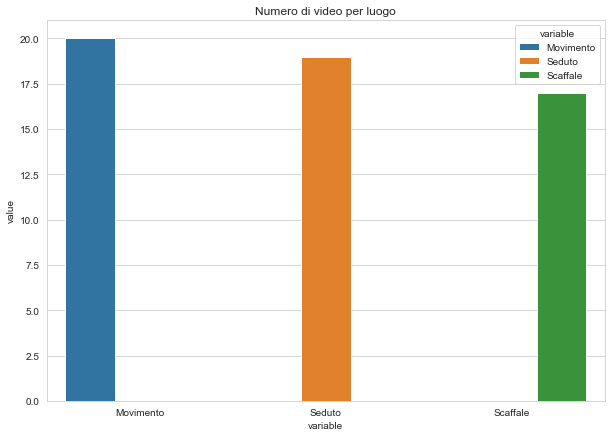

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.barplot(data = pd.DataFrame.from_dict([place]).melt(), x = "variable", y="value", hue="variable",  ax=axes).set_title('Numero di video per luogo')